# Freezing Parameters in Optax

This guide demonstrates multiple methods to freeze (i.e. hold constant) subsets of your model's parameters during optimization with Optax. Optax provides ways to do this via `optax.set_to_zero()`, `optax.masked`, and `optix.multi_transform`.



In [38]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

For each of these examples our goal is to minimize the absolute sum of param0 and param1. 

So our loss function becomes:

In [ ]:
def loss_fn(p):
    return jnp.abs(p['param0'][0]) + jnp.abs(p['param1'][0])

### 1. Simple Masked Freezing (True = freeze, False = train)

Use `optax.masked` together with `optax.set_to_zero()` to prevent updates to any parameters marked `True` in the mask. In the snippet below, we freeze `param1` (mask=True) and train `param0` (mask=False) using Adam.


In [39]:
# Define two scalar “parameters”
params = {
    'param0': jnp.array([10.0]),  # will be trained
    'param1': jnp.array([10.0])   # will be frozen
}

# Build a mask: False → train, True → freeze
mask = {
    'param0': False,
    'param1': True
}

# Create optimizer: Adam + masked(set_to_zero)
optimizer = optax.chain(
    optax.adam(0.1),
    optax.masked(optax.set_to_zero(), mask)
)
opt_state = optimizer.init(params)

# Simple L1 loss and training step
@jax.jit
def train_step(p, s):
    loss, grads = jax.value_and_grad(loss_fn)(p)
    updates, s = optimizer.update(grads, s, p)
    new_p = optax.apply_updates(p, updates)
    return new_p, s, loss

# Initialize lists to store loss and parameter values
loss_history = []
param0_history = []
param1_history = []

# Run 200 steps to verify
for i in range(1, 201):
    params, opt_state, loss = train_step(params, opt_state)
    loss_history.append(loss)
    param0_history.append(params['param0'][0])
    param1_history.append(params['param1'][0])
    if i % 50 == 0:
        print(f"Step {i:>3d}  loss={loss:.4f}  "
              f"param0={params['param0'][0]:.4f}  "
              f"param1={params['param1'][0]:.4f}")

# Verify freezing
assert not jnp.isclose(params['param0'][0], 10.0), "param0 should have moved"
assert jnp.isclose   (params['param1'][0], 10.0), "param1 should remain frozen"
print("✅ param1 stayed at 10.0; param0 was optimized toward zero.")


Step  50  loss=15.1000  param0=5.0000  param1=10.0000
Step 100  loss=10.1001  param0=0.0001  param1=10.0000
Step 150  loss=10.0415  param0=0.0274  param1=10.0000
Step 200  loss=10.0060  param0=-0.0246  param1=10.0000
✅ param1 stayed at 10.0; param0 was optimized toward zero.


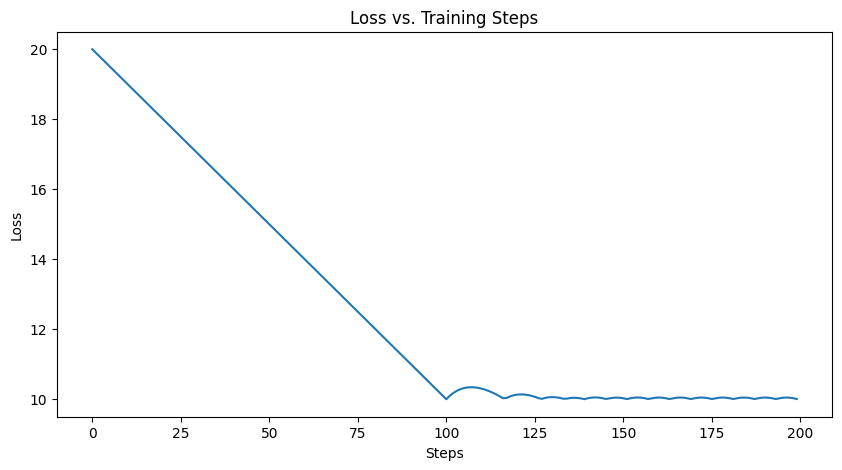

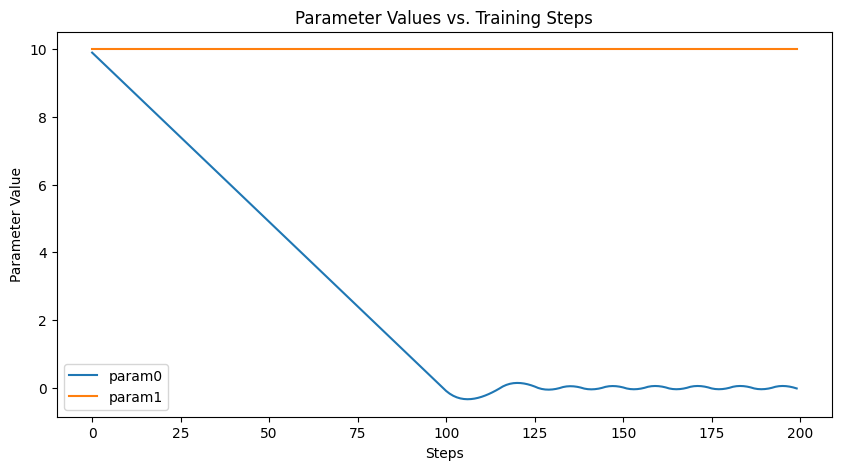

In [40]:
# Plot loss vs. steps
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title('Loss vs. Training Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

# Plot parameter values vs. steps
plt.figure(figsize=(10, 5))
plt.plot(param0_history, label='param0')
plt.plot(param1_history, label='param1')
plt.title('Parameter Values vs. Training Steps')
plt.xlabel('Steps')
plt.ylabel('Parameter Value')
plt.legend()
plt.show()

### 2. Freezing with `multi_transform`

Use `optax.multi_transform` to assign different update rules to each parameter. In this example, we apply Adam to `param0` and completely freeze `param1` by sending it through `optax.set_to_zero()`.


In [41]:
# Create two scalar “parameters”
params = {
    'param0': jnp.array([10.0]),   # will be trained
    'param1': jnp.array([10.0])    # will be frozen
}

# Define two transforms: 'train' → Adam, 'freeze' → zero
transforms = {
    'train':  optax.adam(0.1),
    'freeze': optax.set_to_zero()
}

# Map each param name to one of the transforms
label_map = {
    'param0': 'train',
    'param1': 'freeze'
}

# Build and initialize the optimizer
optimizer = optax.multi_transform(transforms, label_map)
opt_state = optimizer.init(params)

# JIT‑compiled training step
@jax.jit
def train_step(p, s):
    loss, grads = jax.value_and_grad(loss_fn)(p)
    updates, s = optimizer.update(grads, s, p)
    new_p = optax.apply_updates(p, updates)
    return new_p, s, loss

# Initialize lists to store loss and parameter values
loss_history = []
param0_history = []
param1_history = []

# Run a few steps and print progress
for step in range(1, 201):
    params, opt_state, loss = train_step(params, opt_state)
    loss_history.append(loss)
    param0_history.append(params['param0'][0])
    param1_history.append(params['param1'][0])
    if step % 50 == 0:
        print(f"Step {step:>3d}  loss={loss:.4f}  "
              f"param0={params['param0'][0]:.4f}  "
              f"param1={params['param1'][0]:.4f}")

# Verify that param1 stayed frozen
assert jnp.isclose(params['param1'][0], 10.0), "param1 should remain unchanged"
print("✅ multi_transform correctly froze param1!")

Step  50  loss=15.1000  param0=5.0000  param1=10.0000
Step 100  loss=10.1001  param0=0.0001  param1=10.0000
Step 150  loss=10.0415  param0=0.0274  param1=10.0000
Step 200  loss=10.0060  param0=-0.0246  param1=10.0000
✅ multi_transform correctly froze param1!


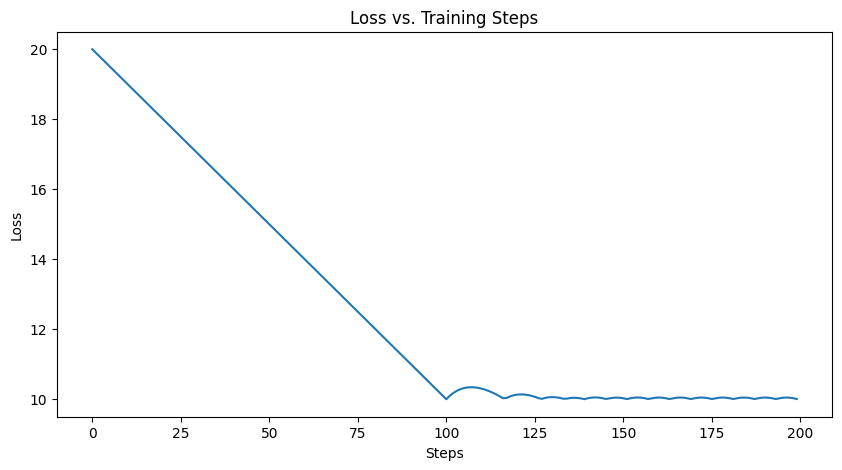

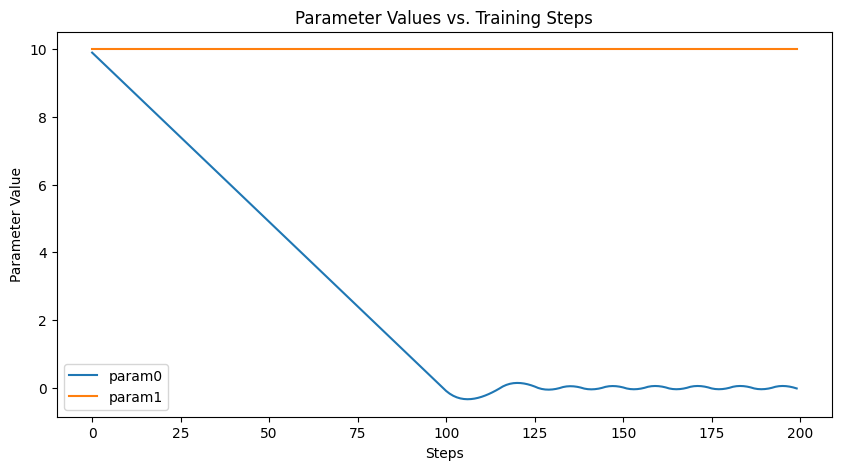

In [42]:
"""This plot will be about the same as the first one"""
# Plot loss vs. steps
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title('Loss vs. Training Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

# Plot parameters vs. steps
plt.figure(figsize=(10, 5))
plt.plot(param0_history, label='param0')
plt.plot(param1_history, label='param1')
plt.title('Parameter Values vs. Training Steps')
plt.xlabel('Steps')
plt.ylabel('Parameter Value')
plt.legend()
plt.show()

### 3. Dynamic Freeze Scheduling with `multi_transform`

In this example, we start by training `param_1` (using Adam) and freezing `param_2` (using `set_to_zero`). At step 100, we swap the roles—freezing `param_1` and training `param_2`—to demonstrate how you can dynamically change which parameters are updated during training.


In [55]:
# Two scalar “params”
params = {
  'param0': jnp.array([10.0]),  # will start trainable
  'param1': jnp.array([10.0])   # will start frozen
}

# Helper to build optimizer given a mask mapping
def make_optimizer(mask):
    return optax.multi_transform(
        {'adam': optax.adam(0.1), 'zero': optax.set_to_zero()},
        mask
    )

# Initial mask: train param0, freeze param1
mask = {'param0': 'adam', 'param1': 'zero'}
optimizer = make_optimizer(mask)
opt_state = optimizer.init(params)

# Initialize lists to store loss and parameter values
loss_history = []
param0_history = []
param1_history = []

# Training loop with dynamic mask swap at step 200
for step in range(1, 401):
    loss_history.append(loss)
    param0_history.append(params['param0'][0])
    param1_history.append(params['param1'][0])
    # At step 200, flip which param is frozen
    if step == 200:
        mask = {'param0': 'zero', 'param1': 'adam'}
        optimizer = make_optimizer(mask)
        opt_state = optimizer.init(params)   # ⚠️ resets Adam state!

    loss, grads = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    if step % 100 == 0:
        print(f"Step {step}: param0={params['param0'][0]:.3f}, "
              f"param1={params['param1'][0]:.3f}, loss={loss:.3f}")

# Verify
assert jnp.isclose(params['param0'][0], 0.0, atol=1e-2)
assert params['param1'][0] != 10.0
print("✅ Dynamic swap worked param0: train→frozen, param1: frozen→train")


Step 100: param0=0.000, param1=10.000, loss=10.100
Step 200: param0=0.006, param1=9.900, loss=10.006
Step 300: param0=0.006, param1=-0.100, loss=0.006
Step 400: param0=0.006, param1=-0.042, loss=0.031
✅ Dynamic swap worked param0: train→frozen, param1: frozen→train


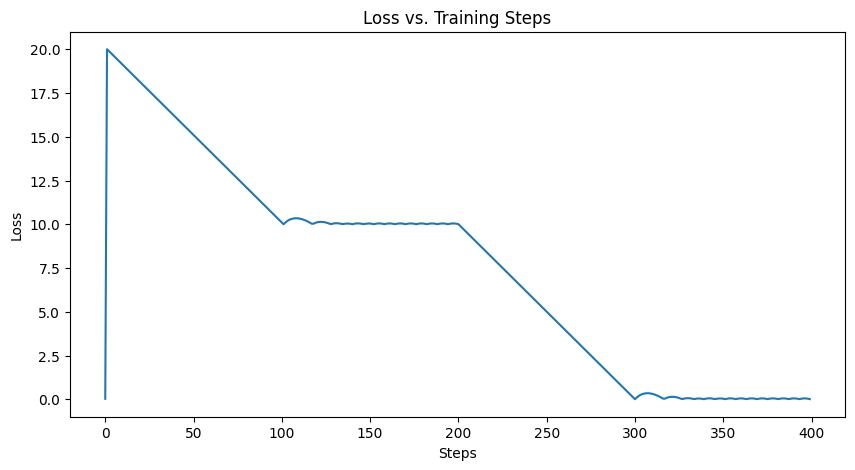

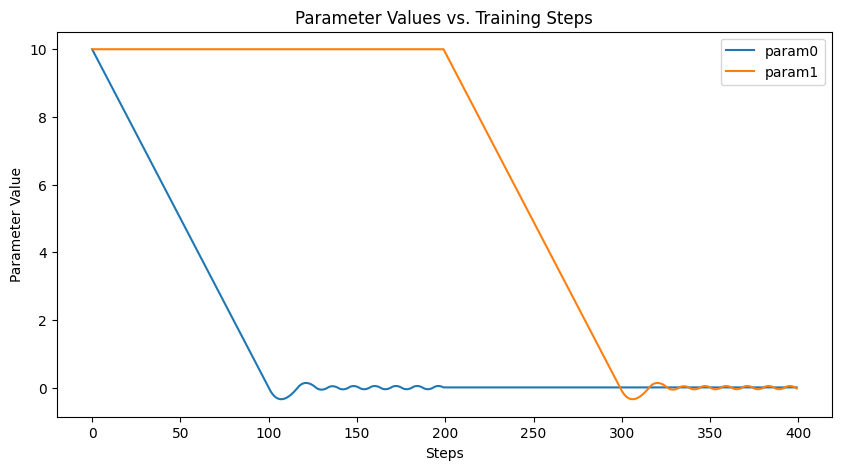

In [56]:
# Plot loss vs. steps
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title('Loss vs. Training Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

# Plot parameter values vs. steps
plt.figure(figsize=(10, 5))
plt.plot(param0_history, label='param0')
plt.plot(param1_history, label='param1')
plt.title('Parameter Values vs. Training Steps')
plt.xlabel('Steps')
plt.ylabel('Parameter Value')
plt.legend()
plt.show()